# Unsupervised Learning Predict
© Explore Data Science Academy

## Honour Code
### Team Members
1. Chinonso Agulonu
2. David Mugambi
3. Farayi Myambo
4. Joy Obukohwo
5. Orisemeke ibude
6. Temitope Olaitan

confirm - by submitting this document - that the solutions in this notebook are a result of our own work and that we abide by the EDSA honour code.

Non-compliance with the honour code constitutes a material breach of contract.

### Predict Overview: Recommender System
In today’s technology driven world, recommender systems are socially and economically critical for ensuring that individuals can make appropriate choices surrounding the content they engage with on a daily basis.

Recommender Systems are a type of information filtering system as they improve the quality of search results and provides items that are more relevant to the search item or are related to the search history of the user.

Almost every major tech company has applied recommender systems in some form: Amazon uses it to suggest products to customers, YouTube uses it to decide which video to play next on autoplay and Facebook uses it to recommend pages to like and people to follow. Furthermore, companies like Netflix and Spotify depend on the effectiveness of their recommendation engines for the success of their business

### Problem statement
Construct a recommendation algorithm capable of accurately predicting how a user will rate a movie they have not yet viewed based on their historical preferences


## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>

<a href=#seven>7. Model Explanations</a>

<a href=#eight>8. Conclusion</a>

<a href=#nine>9. References</a>

 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>

In [50]:
# Data manipulation
import numpy as np 
import pandas as pd   
import re
# Ignore warnings 
import warnings
from collections import Counter

# Data visualization
import matplotlib
import seaborn as sns 
import matplotlib.pyplot as plt 
from wordcloud import WordCloud, STOPWORDS 

# Style
import matplotlib.style as style 
sns.set(font_scale=1.5)
style.use('seaborn-pastel')
sns.set(style="whitegrid")
sns.set_style("dark")

<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [5]:
movies = pd.read_csv('movies.csv')
imdb_data = pd.read_csv('imdb_data.csv')
tags = pd.read_csv('tags.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [36]:
imdb_data.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


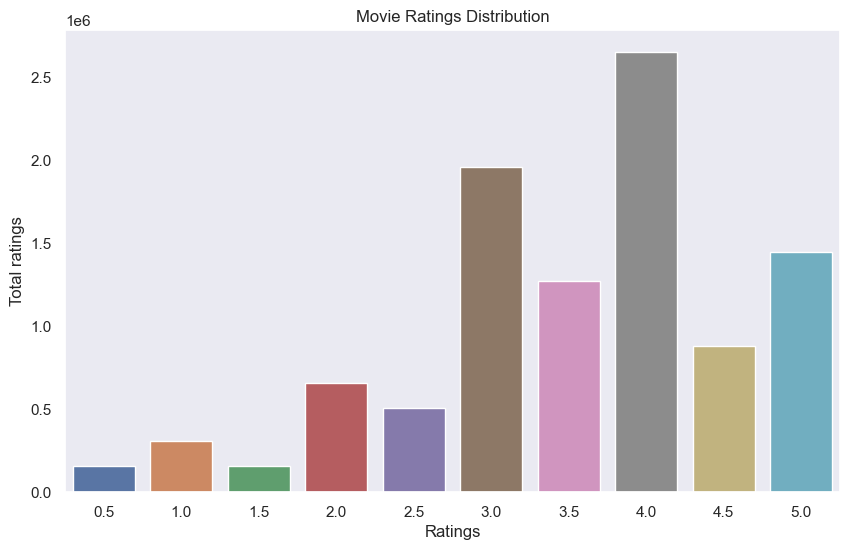

<Figure size 640x480 with 0 Axes>

In [11]:
fig, ax = plt.subplots(figsize = (10, 6))
sns.countplot(data=train, x='rating', ax=ax, )
plt.title('Movie Ratings Distribution')
plt.ylabel("Total ratings")
plt.xlabel('Ratings')
plt.show()
plt.savefig('Movie Ratings Distribution.png')

In [ ]:
# Display the first 5 entries in each dataframe 
print('Movies Table')
display(movies.head())
print('ImDB Data')
display(imdb_data.head())
print('Tags')
display(tags.head())
print('Train')
display(train.head())

In [ ]:
# Count the number of unique entries for features of interest
unique_movies = len(movies['movieId'].unique().tolist())
unique_tags = len(tags['tag'].unique().tolist())
unique_users = len(train['userId'].unique().tolist())
unique_directors = len(imdb_data['director'].unique().tolist())
unique_actors = len(imdb_data['title_cast'].unique().tolist())

# Create a dataframe to store the number of unique entries for features of interest
unique = pd.DataFrame({"movies": [unique_movies],
                       "tags" : [unique_tags],
                       "users": [unique_users],
                       "directors" : [unique_directors],
                       "actors" : [unique_actors]}, index=['unique_entries'])

print('number of unique entries for features of interest')
display(unique.transpose())

In [ ]:
# Determine and display the min and max ratings received
min_rating = train.rating.min()
max_rating = train.rating.max()
print('Lowest rating: {}'.format(min_rating))
print('Highest rating: {}'.format(max_rating))

C:\Users\SHOPINVERSE\AppData\Local\Temp\ipykernel_1736\729896408.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data = train['movieId'].value_counts().sort_values(ascending=False)[0:20]


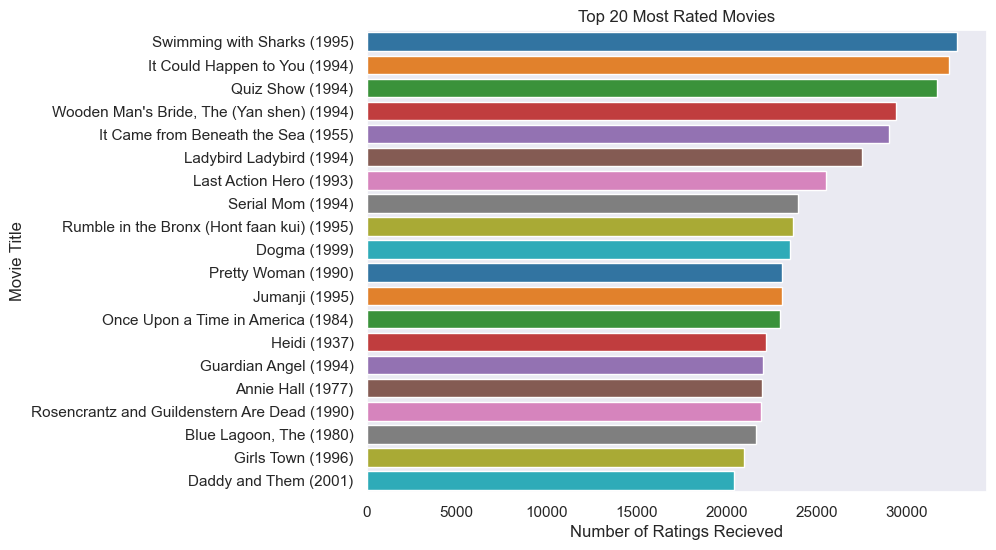

<Figure size 640x480 with 0 Axes>

In [14]:
fig, ax = plt.subplots(figsize = (8, 6))
data = train['movieId'].value_counts().sort_values(ascending=False)[0:20]
titles = [movies.loc[movieId, 'title'] for movieId in data.index]
sns.barplot(y=titles, x=data, ax=ax, palette="tab10")
plt.title('Top 20 Most Rated Movies')
plt.ylabel("Movie Title")
plt.xlabel("Number of Ratings Recieved")
plt.show()
plt.savefig('Top 20 Most Rated Movies.png')

#### Observations:

- There are a few tables with more information about the movies, these are all related by the movieId key
- Available information about each movie: Title, cast, runtime, budget, director, genre, plot keywords, tags and ratings
- There are just more than 60000 unique movies and 160000 unique users in the dataset
- There are more unique tags than unique movies in the dataset
- Movies are rated between 0 and 5 with the lowest rating being 0.5 and the highest 5.
- We are also given the timestamp for each rating which isn't particularly useful for our model development since the time rating has nothing to do with a user's preferences or the quality of a film. The timestamps could, however, provide some meaningful insights in our EDA

#### Preparing the data for better visualization
We start by selecting the movie features we want to investigate and create a new dataframe containing these features.

In [ ]:
df = imdb_data[['movieId','title_cast','director', 'plot_keywords']]
df = df.merge(movies[['movieId', 'genres', 'title']], on='movieId', how='inner')
df.head()

In [ ]:
# Convert data types to strings for string handling
df['title_cast'] = df.title_cast.astype(str)
df['plot_keywords'] = df.plot_keywords.astype(str)
df['genres'] = df.genres.astype(str)
df['director'] = df.director.astype(str)

# Removing spaces between names
df['director'] = df['director'].apply(lambda x: "".join(x.lower() for x in x.split()))
df['title_cast'] = df['title_cast'].apply(lambda x: "".join(x.lower() for x in x.split()))

# Discarding the pipes between the actors' full names and getting only the first three names
df['title_cast'] = df['title_cast'].map(lambda x: x.split('|')[:3])

# Discarding the pipes between the plot keywords' and getting only the first five words
df['plot_keywords'] = df['plot_keywords'].map(lambda x: x.split('|')[:5])
df['plot_keywords'] = df['plot_keywords'].apply(lambda x: " ".join(x))

# Discarding the pipes between the genres 
df['genres'] = df['genres'].map(lambda x: x.lower().split('|'))
df['genres'] = df['genres'].apply(lambda x: " ".join(x))

df.head()

#### MovieLens rating distribution

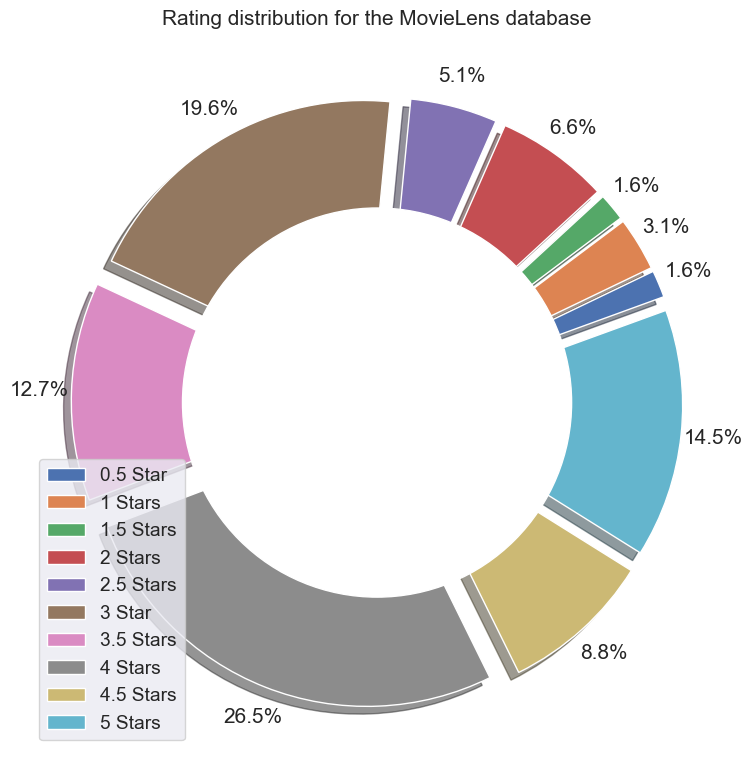

<Figure size 640x480 with 0 Axes>

In [17]:
# Merge train with movies to join movie titles and ratings 
ratings = train.merge(movies, on='movieId', how='inner')
ratings.drop('timestamp', axis=1, inplace=True)

# Count how many ratings are in each category (1 star, 2 star, ect)
grouped = pd.DataFrame(ratings.groupby(['rating'])['title'].count())
grouped.rename(columns={'title':'rating_count'}, inplace=True)

# Creating plots 
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(122)
    
# Create colour palette
labels = ['0.5 Star', '1 Stars', '1.5 Stars', '2 Stars', '2.5 Stars', '3 Star', '3.5 Stars', '4 Stars', '4.5 Stars', '5 Stars']
#theme = plt.get_cmap('Blues')
#ax.set_prop_cycle("color", [theme(1. * i / len(labels))
#                                 for i in range(len(labels))])
sns.set(font_scale=1.25)

# Create pie chart
pie = ax.pie(grouped['rating_count'],
                 autopct='%1.1f%%',
                 shadow=True,
                 startangle=20,
                 pctdistance=1.115,
                 explode=(0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1))
   
# Turn pie chart into a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Display donut plot with legend
plt.legend(pie[0], labels, loc="lower left")
ax.set_title('Rating distribution for the MovieLens database\n', fontsize=15)
plt.tight_layout()
plt.show()
plt.savefig('Distribution of Ratings.png')

#### Distribution of average ratings

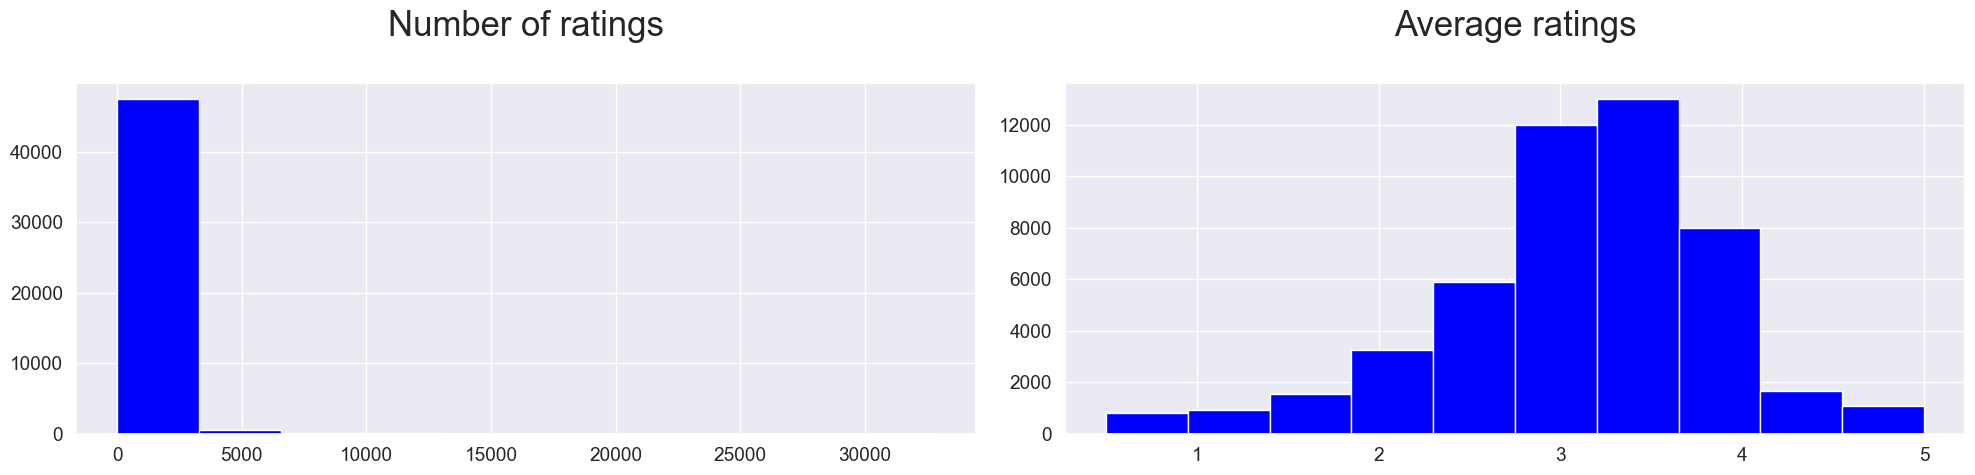

<Figure size 640x480 with 0 Axes>

In [19]:
# Determine the average rating and number of ratings for each movie
ratings_mean_count = pd.DataFrame(ratings.groupby(['title'])[['rating']].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(ratings.groupby(['title'])['rating'].count())
ratings_mean_count['popularity'] = pd.DataFrame(ratings.groupby(['title'])['rating'].count()*ratings.groupby(['title'])['rating'].mean())

# Create a plot of the number of ratings 
f, axarr = plt.subplots(1,2, figsize=(20,5))
axarr[0].hist(ratings_mean_count['rating_counts'], bins=10, color='Blue')
axarr[0].set_title('Number of ratings\n', fontsize=25)

# Create a plot showing the average ratings distribution 
axarr[1].hist(ratings_mean_count['rating'], bins=10, color='Blue')
axarr[1].set_title('Average ratings\n', fontsize=25)

# Display both plots
plt.tight_layout()
plt.show()
plt.savefig('Average Distribution of Ratings.png')

##### Release Year of different movies

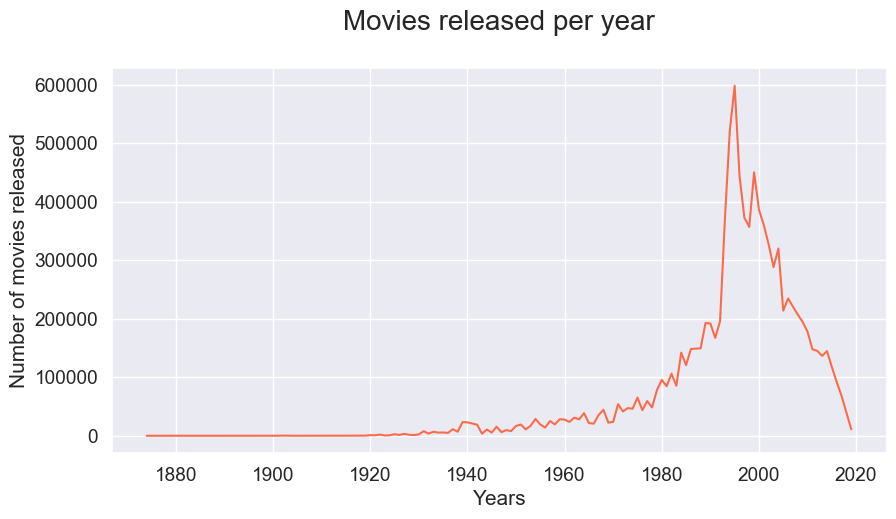

<Figure size 640x480 with 0 Axes>

In [21]:
# Extract the release year fron the movie titles
ratings['release_year'] = ratings.title.map(lambda x: re.findall('\d\d\d\d', x))
ratings.release_year = ratings.release_year.apply(lambda x: np.nan if not x else int(x[-1]))
years =  pd.DataFrame(ratings.groupby(['release_year'])['title'].count())
years.rename(columns={'title':'movies released'}, inplace=True)

# Plot the number of movies released per year
plt.figure(figsize=(10,5))
plot = sns.lineplot(data=years, dashes=False, legend=False, palette='Reds_r')

# Add figure labels
plt.xlabel('Years', fontsize=15)
plt.ylabel('Number of movies released', fontsize=15)
plt.title('Movies released per year\n', fontsize=20)

plt.show()
plt.savefig('Movie release per year.png')

#### Best Movies

In [22]:
# Extract and display the 10 most popular films in the dataset 
ratings_mean_count = ratings_mean_count.sort_values(by='popularity', ascending=False).head(10)
ratings_mean_count.head(10)

,rating,rating_counts,popularity
title,,,
"Shawshank Redemption, The (1994)",4.417624,32831,145035.0
Pulp Fiction (1994),4.195097,31697,132972.0
Forrest Gump (1994),4.047216,32383,131061.0
"Silence of the Lambs, The (1991)",4.144172,29444,122021.0
"Matrix, The (1999)",4.154253,29014,120531.5
Star Wars: Episode IV - A New Hope (1977),4.111811,27560,113321.5
Schindler's List (1993),4.247625,24004,101960.0
Fight Club (1999),4.227906,23536,99508.0
Star Wars: Episode V - The Empire Strikes Back (1980),4.146236,22956,95181.0


Let's take a closer look at how the ratings for the most popular movie are distributed - Shawshank Redemption

C:\Users\SHOPINVERSE\AppData\Local\Temp\ipykernel_1736\2444430174.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top.rating[top.rating == 0.5] = 2
C:\Users\SHOPINVERSE\AppData\Local\Temp\ipykernel_1736\2444430174.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top.rating[top.rating == 0.5] = 2
C:\Users\SHOPINVERSE\AppData\Local\Temp\ipykernel_1736\2444430174.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top.rating[top.ra

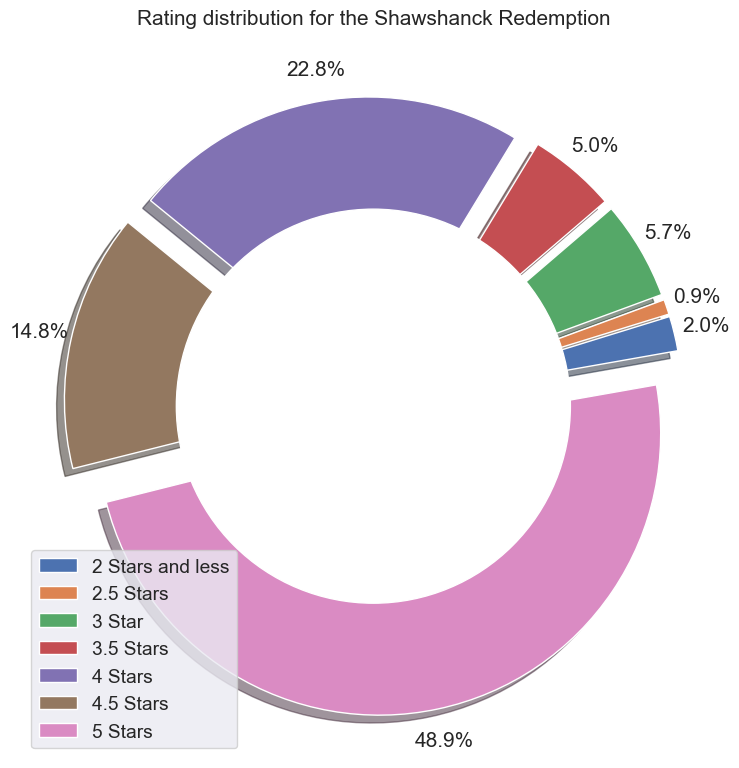

<Figure size 640x480 with 0 Axes>

In [26]:
# Extract shawshank redemption ratings
top = ratings[ratings['title']=='Shawshank Redemption, The (1994)']

# Group all 2 star and lower ratings together
top.rating[top.rating == 0.5] = 2 
top.rating[top.rating == 1] = 2 
top.rating[top.rating == 1.5] = 2 

# Count how many ratings are in each category: 1 star, 2 star, ect
grouped = pd.DataFrame(top.groupby(['rating'])['title'].count())
grouped.rename(columns={'title':'rating_count'}, inplace=True)

# Create the figure
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(122)
    
# Create the colour palette
labels = ['2 Stars and less', '2.5 Stars', '3 Star', '3.5 Stars', '4 Stars', '4.5 Stars', '5 Stars']
#theme = plt.get_cmap('Blues')
#ax.set_prop_cycle("color", [theme(1. * i / len(labels))
#                                 for i in range(len(labels))])
sns.set(font_scale=1.25)

# Create the pie chart
pie = ax.pie(grouped['rating_count'],
                 autopct='%1.1f%%',
                 #labels=labels, 
                 shadow=True,
                 startangle=10,
                 pctdistance=1.115,
                 explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1))
   
# Turn the pie chart into a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Display the donut chart with a legend
ax.set_title('Rating distribution for the Shawshanck Redemption\n', fontsize=15)
plt.legend(pie[0], labels, loc="lower left")
plt.tight_layout()
plt.show()
plt.savefig('Rating distribution for the Shawshanck Redemption.png')

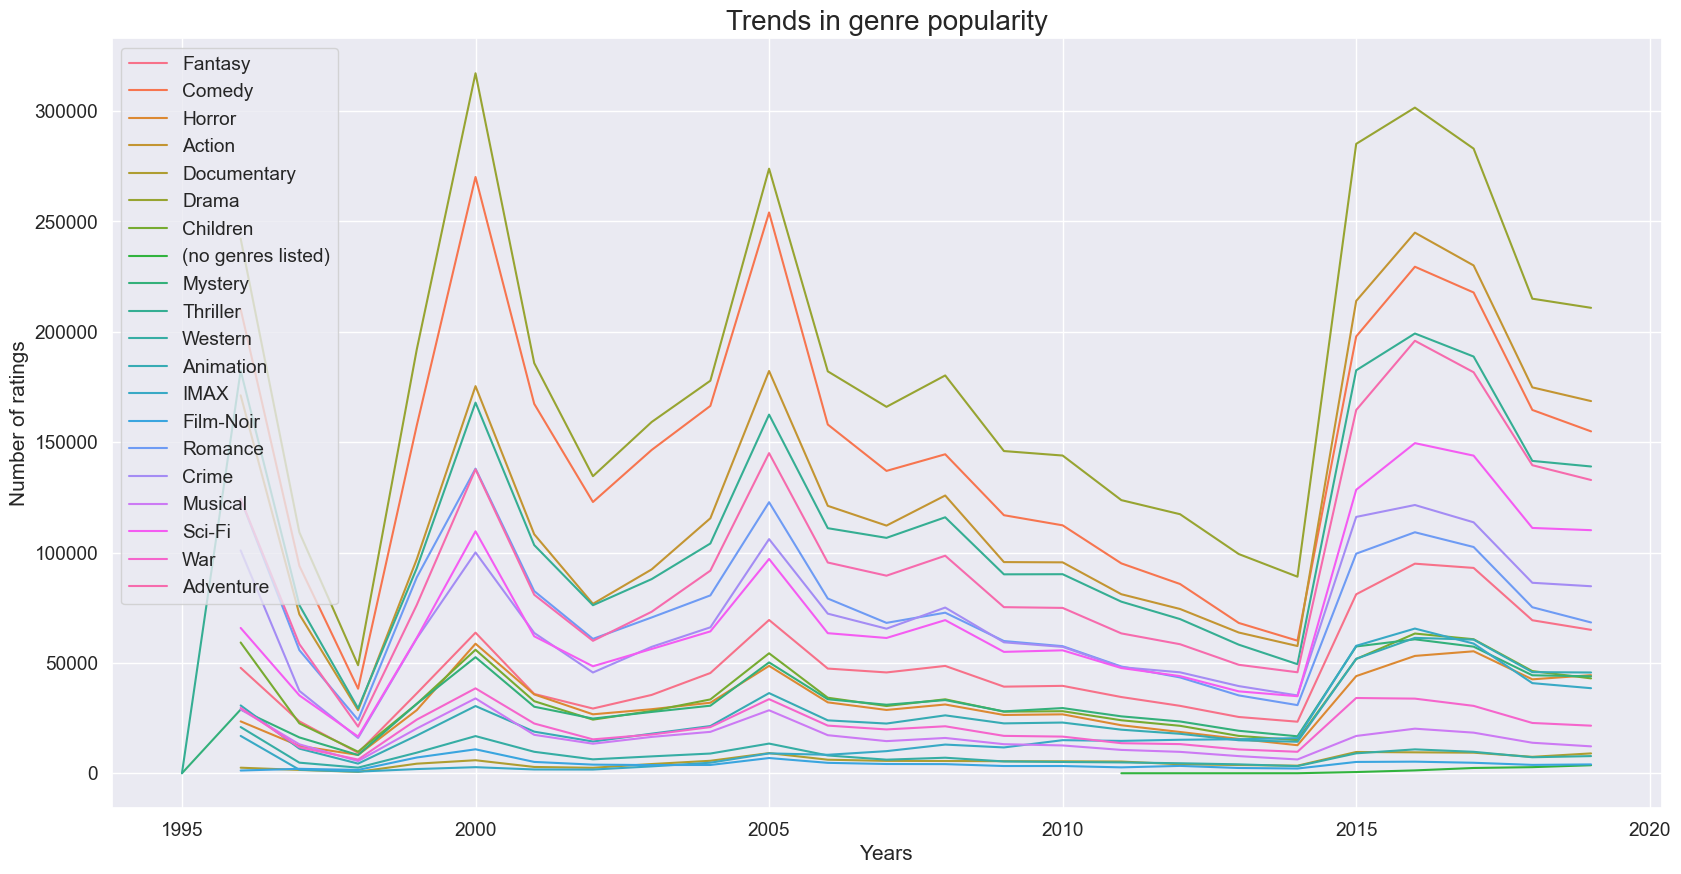

<Figure size 640x480 with 0 Axes>

In [27]:
def most_watched(input_df):  
    """"
    This function creates a plot showing the popularity of each genre 
    over the last 50 years.
    
    Input: input_df
           datatype: DataFrame
           
    Output: None
    
    """   
    # Create a copy of the input dataframe and merge it to the movies dataframe
    df = input_df.copy()
    df = df.merge(movies,on='movieId',how='left')
    
    # Create an empty dataframe
    b = pd.DataFrame()
    
    # Extract the timestamps and genres 
    timestamps = [timestamp for timestamp in df.timestamp]
    all_genres = set(','.join([genres.replace('|',',') for genres in df.genres]).split(','))
    
    # Get the number of ratings for each genre for each year since 1970
    for index,genre in enumerate(all_genres):
        a = pd.Series([int((timestamps[i]/31536000)+1970) for i,x in enumerate(df.genres) if genre in x])
        a = a.value_counts()
        b = pd.concat([b,pd.DataFrame({genre:a})],axis=1)
    
    # Plot the trends for each genre on the same line graph 
    plt.figure(figsize=(20,10))
    plot = sns.lineplot(data=b, dashes=False)
      
    # Add plot labels
    plt.title('Trends in genre popularity',fontsize=20)
    plt.xlabel('Years', fontsize=15)
    plt.ylabel('Number of ratings', fontsize=15)
    
    plt.show()
    plt.savefig('Trend in genre popularity.png')
    return

most_watched(train)

Lets have a look at the most frequently occuring plot keywords in the movielens dataset

In [ ]:
def wordcloud_generator(df, column):  
    """
    This function extracts all the unique keywords in a column
    and counts the number of times each keyword occurs in the column
    while ignoring words that are not meaningful.
    these keywords are then used to generate a word cloud 
    
    Input: df
           datatype: DataFrame
           column
           datatype: str
           
    Output: wordcloud
            Datatype: None
            
    """    
    keyword_counts = {}
    keyword_pair = []
    words = dict()
    
    # list of words that should be ignored
    ignore = ['nan', ' nan', 'nan ', 'seefullsummary', ' seefullsummary', 'seefullsummary ']
    
    # Extract the unique keywords 
    for keyword in [keyword for keyword in df[column] if keyword not in ignore]:
        if keyword in keyword_counts.keys():
            keyword_counts[keyword] += 1
        else:
            keyword_counts[keyword] = 1
     
    # Pair the keywords with their frequencies
    for word,word_freq in keyword_counts.items():
        keyword_pair.append((word,word_freq))
       
    # Sort the keywords accprding to their frequencies
    keyword_pair.sort(key = lambda x: x[1],reverse=True)
    
    # Make it wordcloud-ready
    for s in keyword_pair:
        words[s[0]] = s[1]
        
    # Create a wordcloud using the top 2000 keywords
    wordcloud = WordCloud(width=800, 
                          height=500, 
                          background_color='black', 
                          max_words=2000,
                          max_font_size=110,
                          scale=3,
                          random_state=0,
                          colormap='Reds').generate_from_frequencies(words)

    return wordcloud 

# Plot wordcloud
plot_keywords = wordcloud_generator(imdb_data, 'plot_keywords')
f = plt.figure(figsize=(20, 8)) 
plt.imshow(plot_keywords) 
plt.axis('off') 
plt.title('Plot keywords\n', fontsize=25)
plt.show()
plt.savefig('Keywords WORDCLOUD.png')

Movie directors

In [45]:
# Generate a WordCloud using the movie directors  
directors = wordcloud_generator(df, 'director')

# Plot the WordCloud 
f = plt.figure(figsize=(20, 8)) 
plt.imshow(directors) 
plt.axis('off') 
plt.title('Movie directors\n', fontsize=25)
plt.show()
plt.savefig('Directors WORDCLOUD.png')

NameError: name 'df' is not defined

Actors

In [46]:
# Generate a wordcloud using the 2000 most frequently occuring actors' names in the dataset
df['title_cast'] = df['title_cast'].apply(lambda x: " ".join(x))
actors = wordcloud_generator(df, 'title_cast')

# plot the WordCloud                        
f = plt.figure(figsize=(20, 8)) 
plt.imshow(actors) 
plt.axis('off') 
plt.title('Actors\n', fontsize=25)
plt.show()
plt.savefig('Actors WORDCLOUD.png')

NameError: name 'df' is not defined

C:\Users\SHOPINVERSE\AppData\Local\Temp\ipykernel_1736\3705094060.py:13: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data = data.groupby('movieId')['rating'].mean().sort_values(ascending=False)[start:stop]
C:\Users\SHOPINVERSE\AppData\Local\Temp\ipykernel_1736\3705094060.py:13: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data = data.groupby('movieId')['rating'].mean().sort_values(ascending=False)[start:stop]
C:\Users\SHOPINVERSE\AppData\Local\Temp\ipykernel_1736\3705094060.py

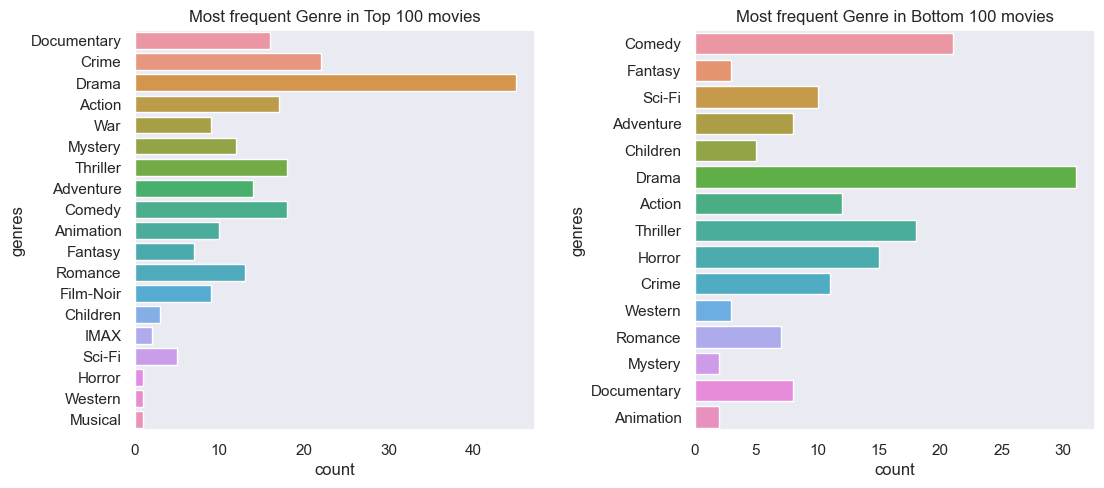

<Figure size 640x480 with 0 Axes>

In [55]:
### PLOT MOST FREQUENT FOR TOP and BOTTOM 100 movies

def most_popular(start, stop):
    # Excluding ratings that are less than 50
    movies_per_rating = dict(Counter(train.movieId))
    required_movies = []
    for key, value in movies_per_rating.items():
        if value > 50:
            required_movies.append(key)
    data = train[train['movieId'].isin(required_movies)]

    # calling the average rating of movies
    data = data.groupby('movieId')['rating'].mean().sort_values(ascending=False)[start:stop]
    return data

data = most_popular(0,10)

fig, ax = plt.subplots(1,2, figsize=(12,5))

all_genres = []
data = most_popular(0, 100)
genres = [movies[movies['movieId'] == movieId]['genres'].iloc[0] for movieId in data.index]
genres = [all_genres.extend(x.split("|")) for x in genres if x != '(no genres listed)']
genres = pd.DataFrame({"genres":all_genres})
sns.countplot(y='genres', data=genres, ax=ax[0])
ax[0].set_title("Most frequent Genre in Top 100 movies")

all_genres = []
data =  train.groupby('movieId')['rating'].mean().sort_values()[0:100]
genres = [movies[movies['movieId'] == movieId]['genres'].iloc[0] for movieId in data.index]
genres = [all_genres.extend(x.split("|")) for x in genres if x != '(no genres listed)']
genres = pd.DataFrame({"genres":all_genres})
sns.countplot(y='genres', data=genres, ax=ax[1])
ax[1].set_title("Most frequent Genre in Bottom 100 movies")

font1 = {'size':10}
plt.subplots_adjust(left=0.1,
                bottom=0.1, 
                right=0.9, 
                top=0.9, 
                wspace=0.4, 
                hspace=0.4)
plt.show()
plt.savefig('Most Frequent TOP & BOTTOM.png')